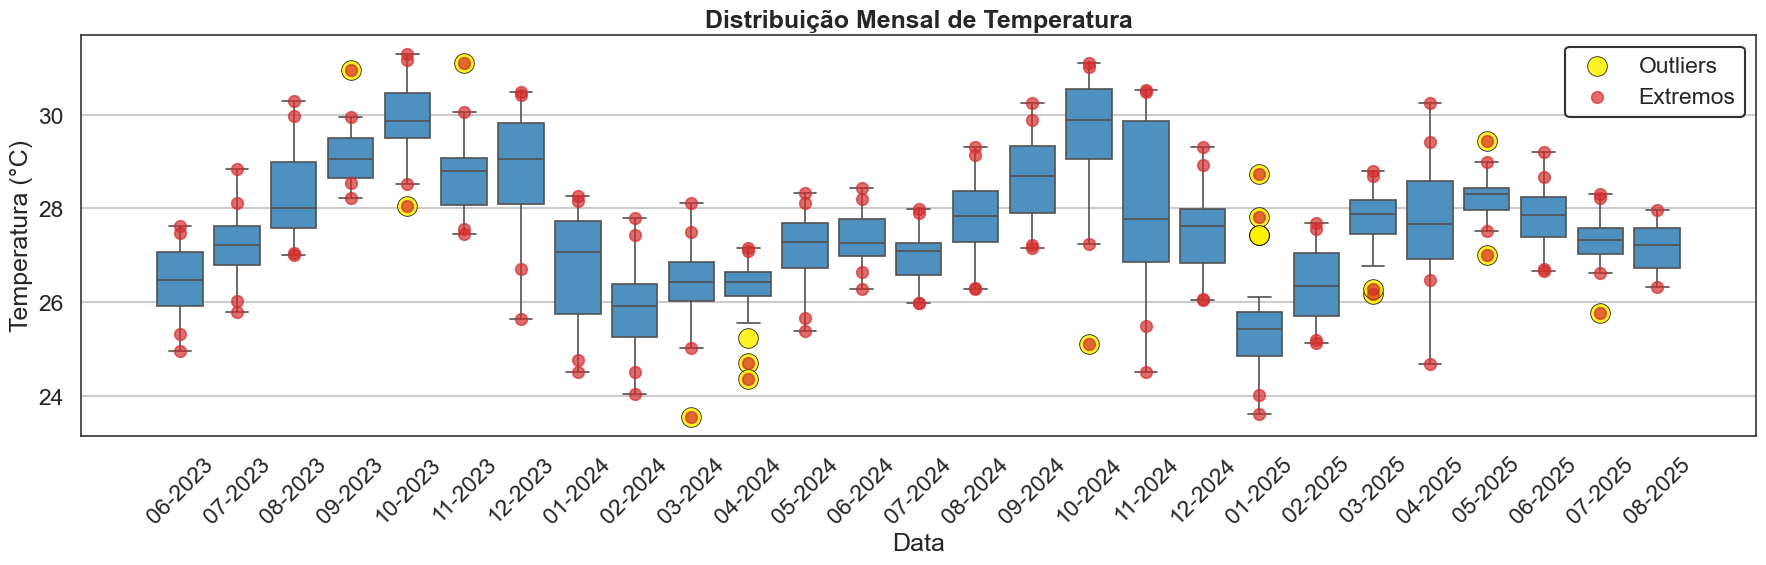

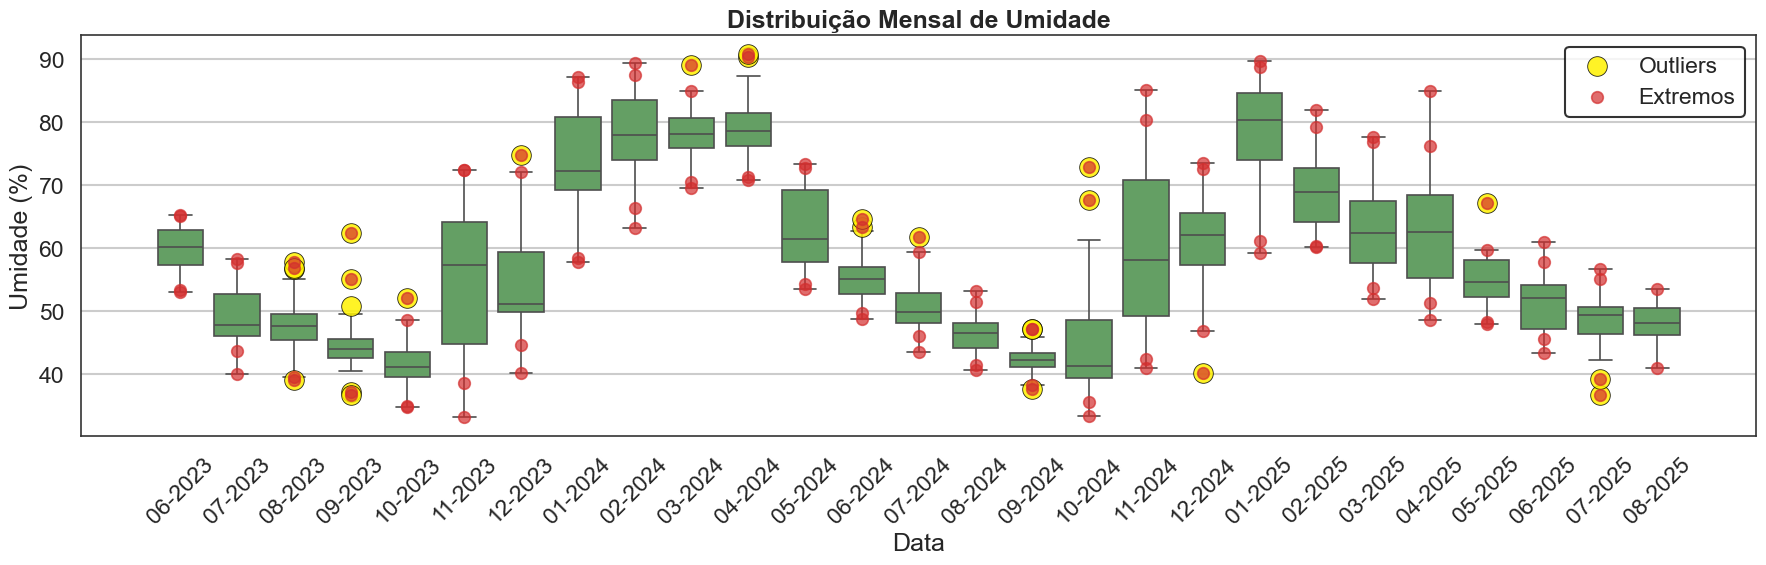

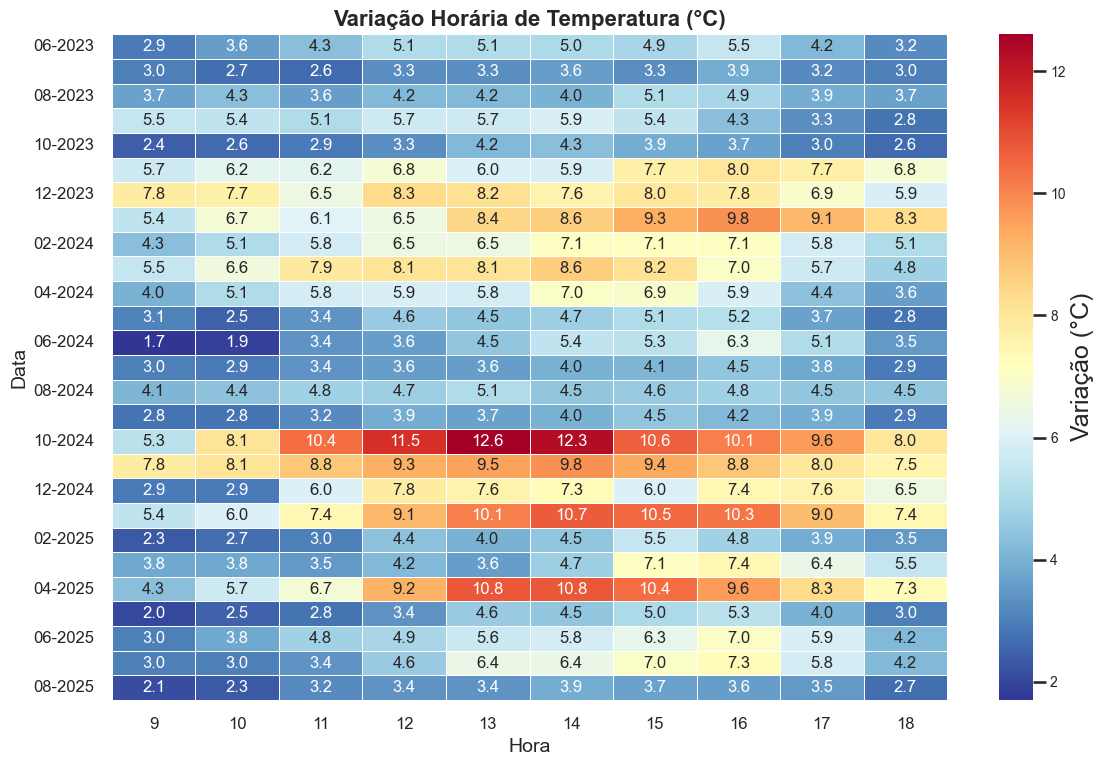


=== Estatísticas Anuais de Temperatura ===
       max   min   p95   p05      media
ano                                    
2022  34.9  17.3  31.9  21.5  26.272441
2023  37.8  19.5  34.6  22.9  28.358283
2024  37.4  18.8  33.3  22.8  27.381853
2025  35.7  19.5  33.3  22.8  27.247904

=== Estatísticas Anuais de Umidade ===
       max   min    p95   p05      media
ano                                     
2022  96.1  16.8  89.50  33.5  63.697931
2023  85.6  15.7  74.14  30.2  50.506534
2024  94.5  15.1  88.10  33.0  61.104850
2025  93.8  19.1  85.90  35.2  60.608272

=== Frequência Anual de Dias Extremos de Temperatura (percentil) ===
      dias_quentes  dias_frios
ano                           
2022            18          18
2023            11          11
2024            19          19
2025            12          12


C:\Users\gustavo.nunes\AppData\Local\Temp\ipykernel_7464\2265060064.py:187: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freq_extremos_anual = df_diario_full.groupby('ano').apply(contar_dias_extremos_ano)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ================================
# ESTILO GLOBAL
# ================================
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 1.2

# ================================
# 1) LEITURA E LIMPEZA DOS DADOS
# ================================
caminho_arquivo = r"seu caminho de arquivo aqui"
df = pd.read_excel(caminho_arquivo, sheet_name="tep", dtype=str)

# Padronizar Temperatura e Umidade (vírgula para ponto e float)
for col in ["Temperatura", "Umidade"]:
    df[col] = df[col].str.replace(",", ".", regex=False).astype(float)

# Converter colunas Ano, Mês, Dia, Hora para int
for col in ["Ano", "Mês", "Dia", "Hora"]:
    df[col] = df[col].astype(int)

# Criar coluna datetime e definir índice
df["datetime"] = pd.to_datetime({
    "year": 2000 + df["Ano"],
    "month": df["Mês"],
    "day": df["Dia"],
    "hour": df["Hora"]
})
df = df.sort_values("datetime").set_index("datetime")

# Tratar duplicatas
df = df[~df.index.duplicated(keep='first')]

# ================================
# 1a) DataFrames separados
# ================================
# Para gráficos: a partir de 01/06/2023
df_grafico = df[df.index >= "2023-06-01"].copy()
df_grafico['hora'] = df_grafico.index.hour
df_grafico['ano_mes'] = df_grafico.index.to_period('M')
df_grafico['ano_mes_str'] = df_grafico['ano_mes'].dt.strftime('%m-%Y')

# Para estatísticas anuais: todos os dados
df_estat = df.copy()
df_estat['ano'] = df_estat.index.year

# ================================
# 2) MÉDIA DIÁRIA E DETECÇÃO DE OUTLIERS/EXTREMOS (GRÁFICOS)
# ================================
df_diario = df_grafico.resample('D').mean(numeric_only=True)
df_diario['ano_mes'] = df_diario.index.to_period('M')
df_diario['ano_mes_str'] = df_diario['ano_mes'].dt.strftime('%m-%Y')

def detectar_outliers_extremos_por_mes(df, coluna, ano_mes_col):
    outliers = pd.Series(False, index=df.index)
    extremos = pd.Series(False, index=df.index)
    for mes, grupo in df.groupby(ano_mes_col):
        Q1, Q3 = grupo[coluna].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        temp_outliers = (grupo[coluna] < Q1 - 1.5*IQR) | (grupo[coluna] > Q3 + 1.5*IQR)
        temp_extremos = (grupo[coluna] < grupo[coluna].quantile(0.05)) | (grupo[coluna] > grupo[coluna].quantile(0.95))
        outliers.loc[grupo.index] = temp_outliers
        extremos.loc[grupo.index] = temp_extremos
    return outliers, extremos

outliers_temp, extremos_temp = detectar_outliers_extremos_por_mes(df_diario, 'Temperatura', 'ano_mes')
outliers_umid, extremos_umid = detectar_outliers_extremos_por_mes(df_diario, 'Umidade', 'ano_mes')

categorias = df_diario['ano_mes_str'].unique()
posicoes = {cat: i for i, cat in enumerate(categorias)}

# ================================
# 3) BOXPLOTS MENSAL COM OUTLIERS/EXTREMOS
# ================================
# --- Temperatura ---
plt.figure(figsize=(18, 6))
sns.boxplot(x='ano_mes_str', y='Temperatura', data=df_diario, 
            color="#3b93d2", fliersize=0, linewidth=1.2)
x_outliers = [posicoes[mes] for mes in df_diario.loc[outliers_temp, 'ano_mes_str']]
y_outliers = df_diario.loc[outliers_temp, 'Temperatura']
plt.scatter(x_outliers, y_outliers, color='#FFF200', s=200, edgecolor='black', linewidth=0.6, alpha=0.85, label='Outliers', zorder=3)
x_extremos = [posicoes[mes] for mes in df_diario.loc[extremos_temp, 'ano_mes_str']]
y_extremos = df_diario.loc[extremos_temp, 'Temperatura']
plt.scatter(x_extremos, y_extremos, color='#d32f2f', s=70, linewidth=1.2, alpha=0.7, label='Extremos', zorder=3)
plt.title('Distribuição Mensal de Temperatura', fontsize=18, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend(frameon=True, facecolor='white', edgecolor='black')
plt.xticks(ticks=range(len(categorias)), labels=categorias, rotation=45)
plt.tight_layout()
plt.show()

# --- Umidade ---
plt.figure(figsize=(18, 6))
sns.boxplot(x='ano_mes_str', y='Umidade', data=df_diario, 
            color="#5aa95a", fliersize=0, linewidth=1.2)
x_outliers = [posicoes[mes] for mes in df_diario.loc[outliers_umid, 'ano_mes_str']]
y_outliers = df_diario.loc[outliers_umid, 'Umidade']
plt.scatter(x_outliers, y_outliers, color="#FFF200", s=200, edgecolor='black', linewidth=0.6, alpha=0.85, label='Outliers', zorder=3)
x_extremos = [posicoes[mes] for mes in df_diario.loc[extremos_umid, 'ano_mes_str']]
y_extremos = df_diario.loc[extremos_umid, 'Umidade']
plt.scatter(x_extremos, y_extremos, color='#d32f2f', s=70, linewidth=1.2, alpha=0.7, label='Extremos', zorder=3)
plt.title('Distribuição Mensal de Umidade', fontsize=18, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Umidade (%)')
plt.legend(frameon=True, facecolor='white', edgecolor='black')
plt.xticks(ticks=range(len(categorias)), labels=categorias, rotation=45)
plt.tight_layout()
plt.show()

# ================================
# 4) HEATMAP DE VARIAÇÃO HORÁRIA (09h-18h)
# ================================
def calcular_variacao(df, coluna, ano_mes_col, hora_col):
    resultados = []
    for (mes, hora), grupo in df.groupby([ano_mes_col, hora_col]):
        variacao = grupo[coluna].max() - grupo[coluna].min()
        resultados.append({'ano_mes': mes, 'hora': hora, 'variacao': variacao})
    return pd.DataFrame(resultados)

variacao_df = calcular_variacao(df_grafico, 'Temperatura', 'ano_mes', 'hora')
heatmap_data = variacao_df.pivot(index='ano_mes', columns='hora', values='variacao')
horas_desejadas = list(range(9, 19))
heatmap_recortado = heatmap_data[horas_desejadas]
heatmap_recortado.index = heatmap_recortado.index.to_timestamp().strftime('%m-%Y')

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    heatmap_recortado,
    cmap='RdYlBu_r',
    annot=True,
    fmt=".1f",
    linewidths=0.4,
    cbar_kws={'label': 'Variação (°C)'},
    annot_kws={'size':12}
)
plt.title('Variação Horária de Temperatura (°C)', fontsize=16, fontweight='bold')
plt.xlabel('Hora', fontsize=14)
plt.ylabel('Data', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ================================
# 5) ESTATÍSTICAS ANUAIS E FREQUÊNCIA DE DIAS EXTREMOS (INCLUINDO 2022)
# ================================
def calc_estatisticas_anuais(df, coluna):
    agrupado = df.groupby('ano')[coluna]
    maximos = agrupado.max()
    minimos = agrupado.min()
    p95 = agrupado.quantile(0.95)
    p05 = agrupado.quantile(0.05)
    media = agrupado.mean()
    return pd.DataFrame({
        'max': maximos,
        'min': minimos,
        'p95': p95,
        'p05': p05,
        'media': media
    })

estat_temp_anual = calc_estatisticas_anuais(df_estat, 'Temperatura')
estat_umid_anual = calc_estatisticas_anuais(df_estat, 'Umidade')

# Frequência de dias extremos
df_diario_full = df_estat.resample('D').mean(numeric_only=True)
df_diario_full['ano'] = df_diario_full.index.year
percentis_anuais = df_diario_full.groupby('ano')['Temperatura'].quantile([0.05, 0.95]).unstack()

def contar_dias_extremos_ano(g):
    ano_atual = g.name
    lim_inf = percentis_anuais.loc[ano_atual, 0.05]
    lim_sup = percentis_anuais.loc[ano_atual, 0.95]
    dias_quentes = (g['Temperatura'] > lim_sup).sum()
    dias_frios = (g['Temperatura'] < lim_inf).sum()
    return pd.Series({'dias_quentes': dias_quentes, 'dias_frios': dias_frios})

freq_extremos_anual = df_diario_full.groupby('ano').apply(contar_dias_extremos_ano)

print("\n=== Estatísticas Anuais de Temperatura ===")
print(estat_temp_anual)
print("\n=== Estatísticas Anuais de Umidade ===")
print(estat_umid_anual)
print("\n=== Frequência Anual de Dias Extremos de Temperatura (percentil) ===")
print(freq_extremos_anual)
